C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


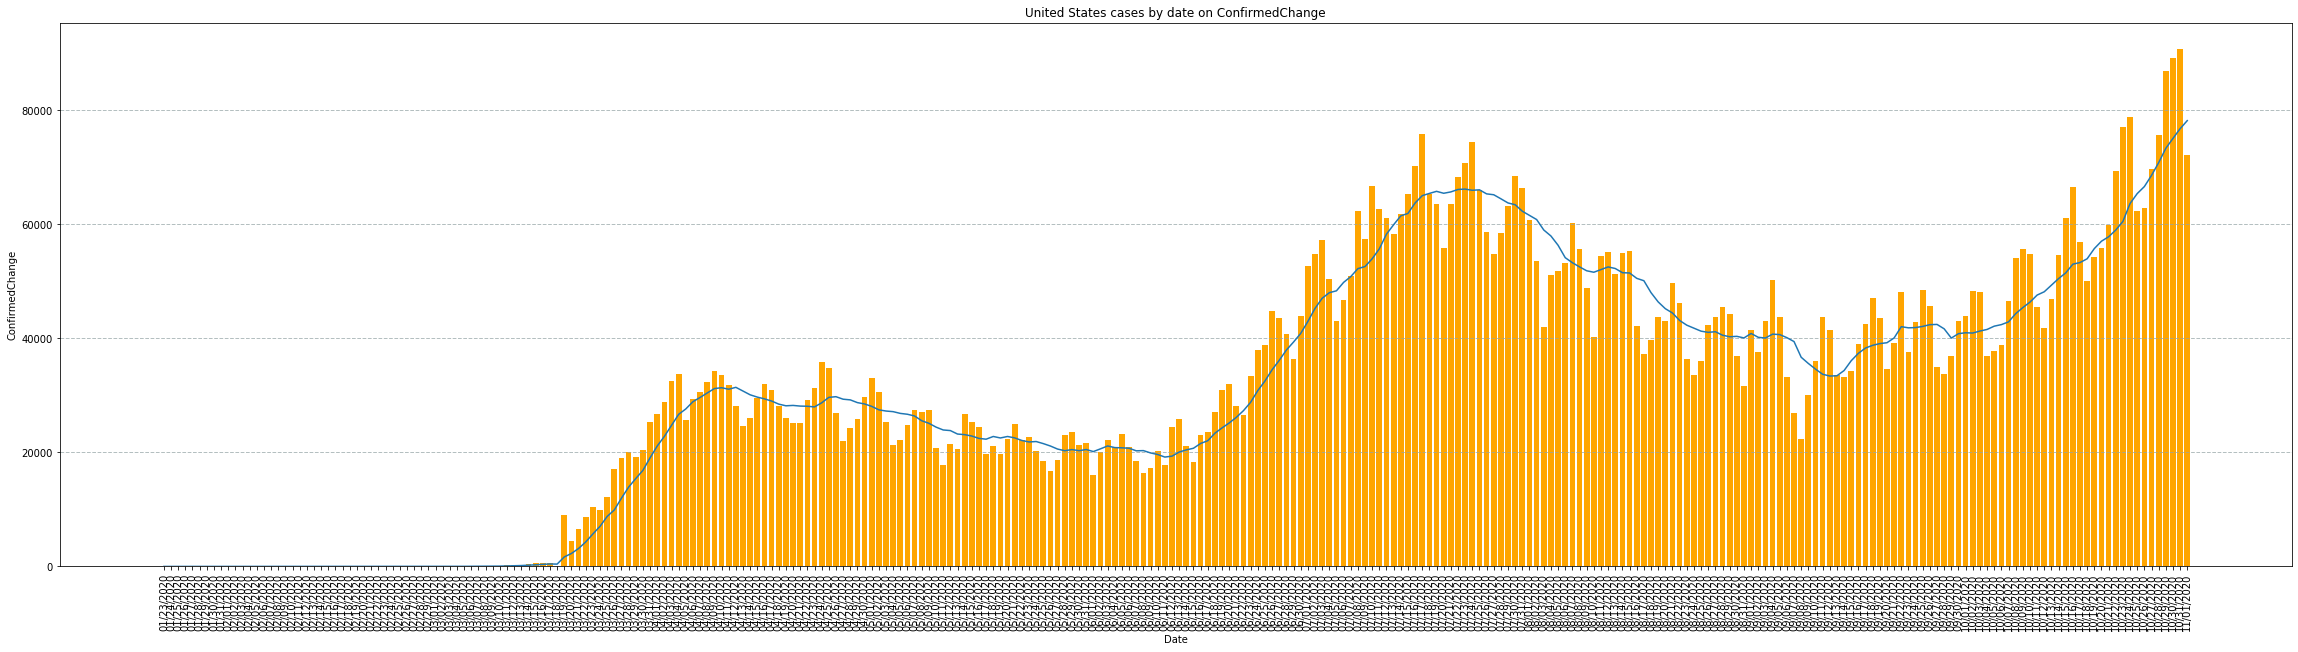

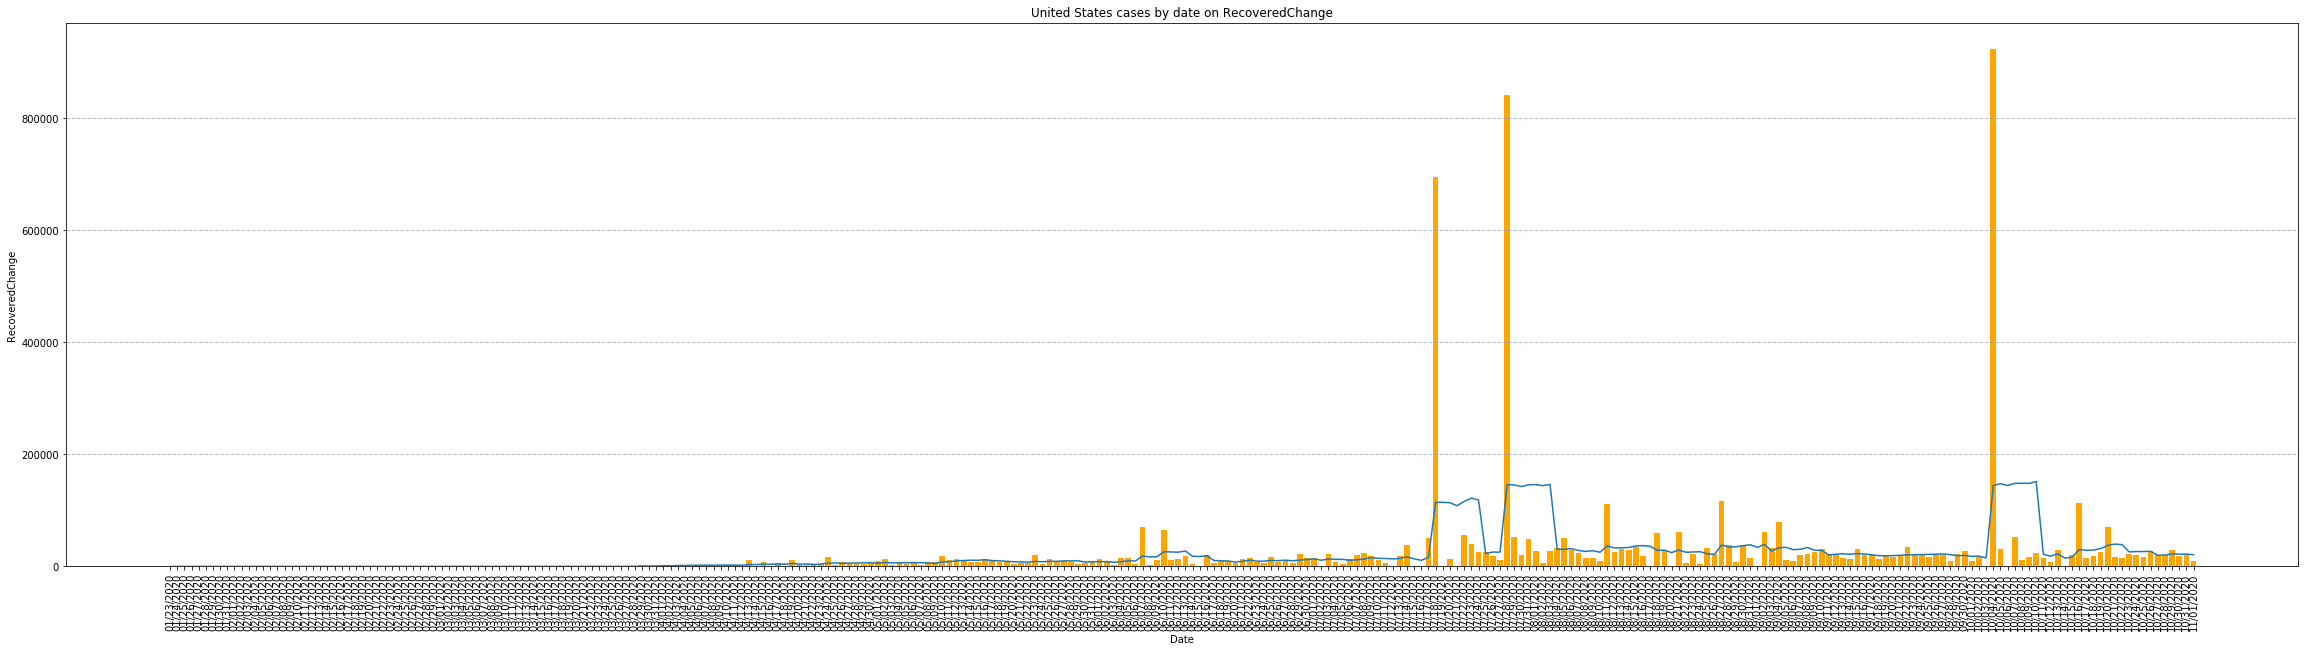

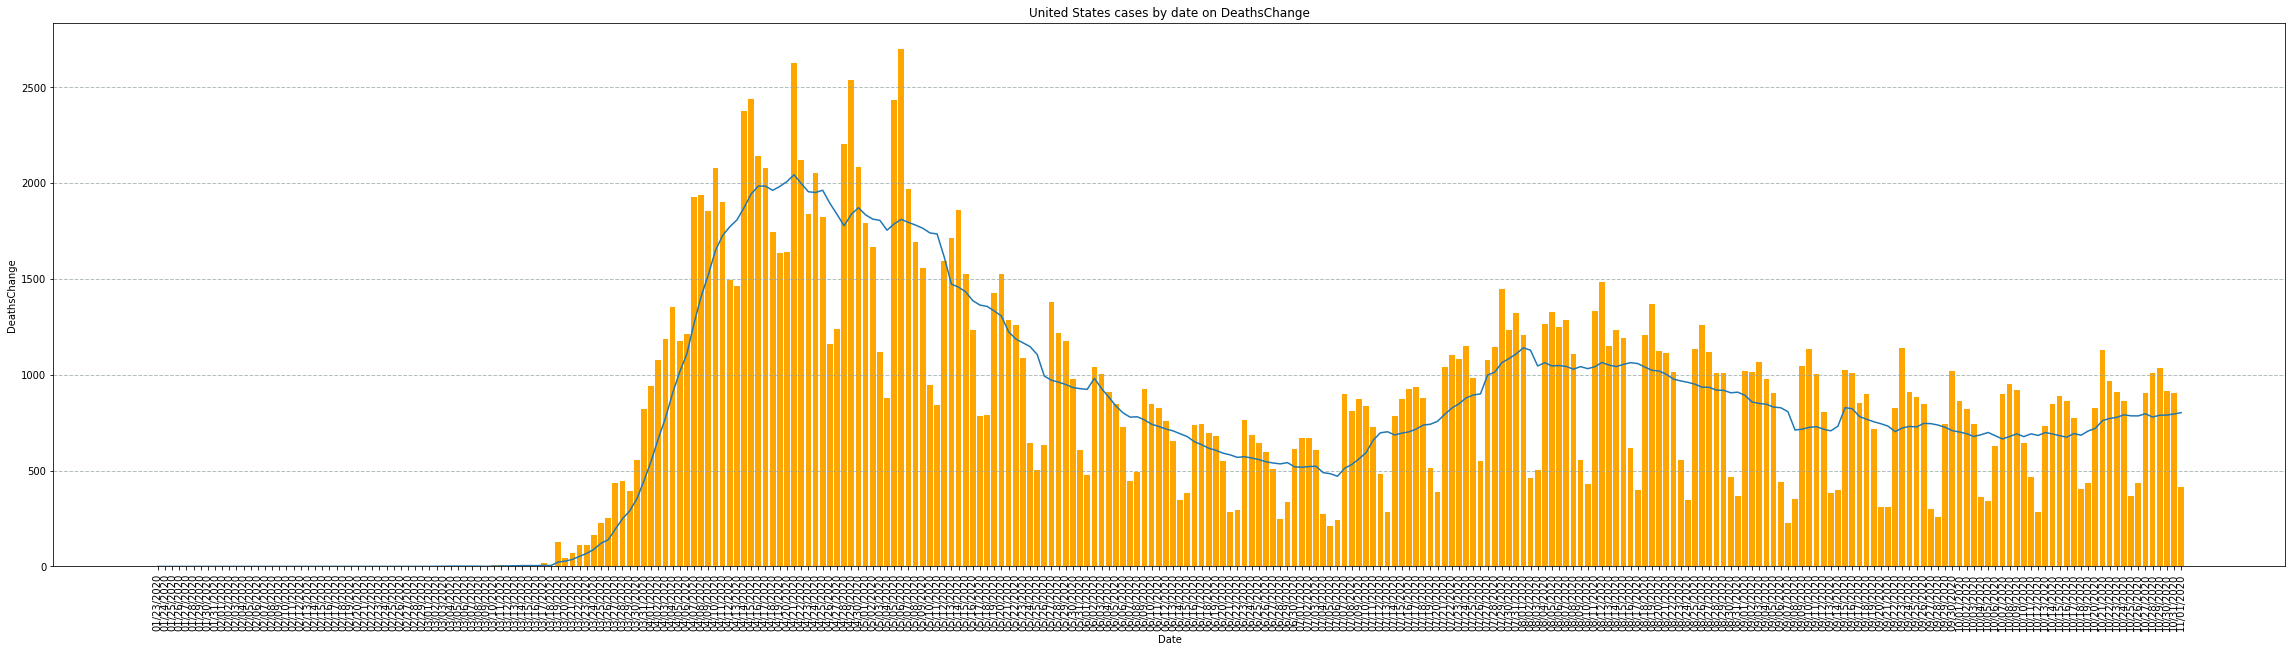

C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


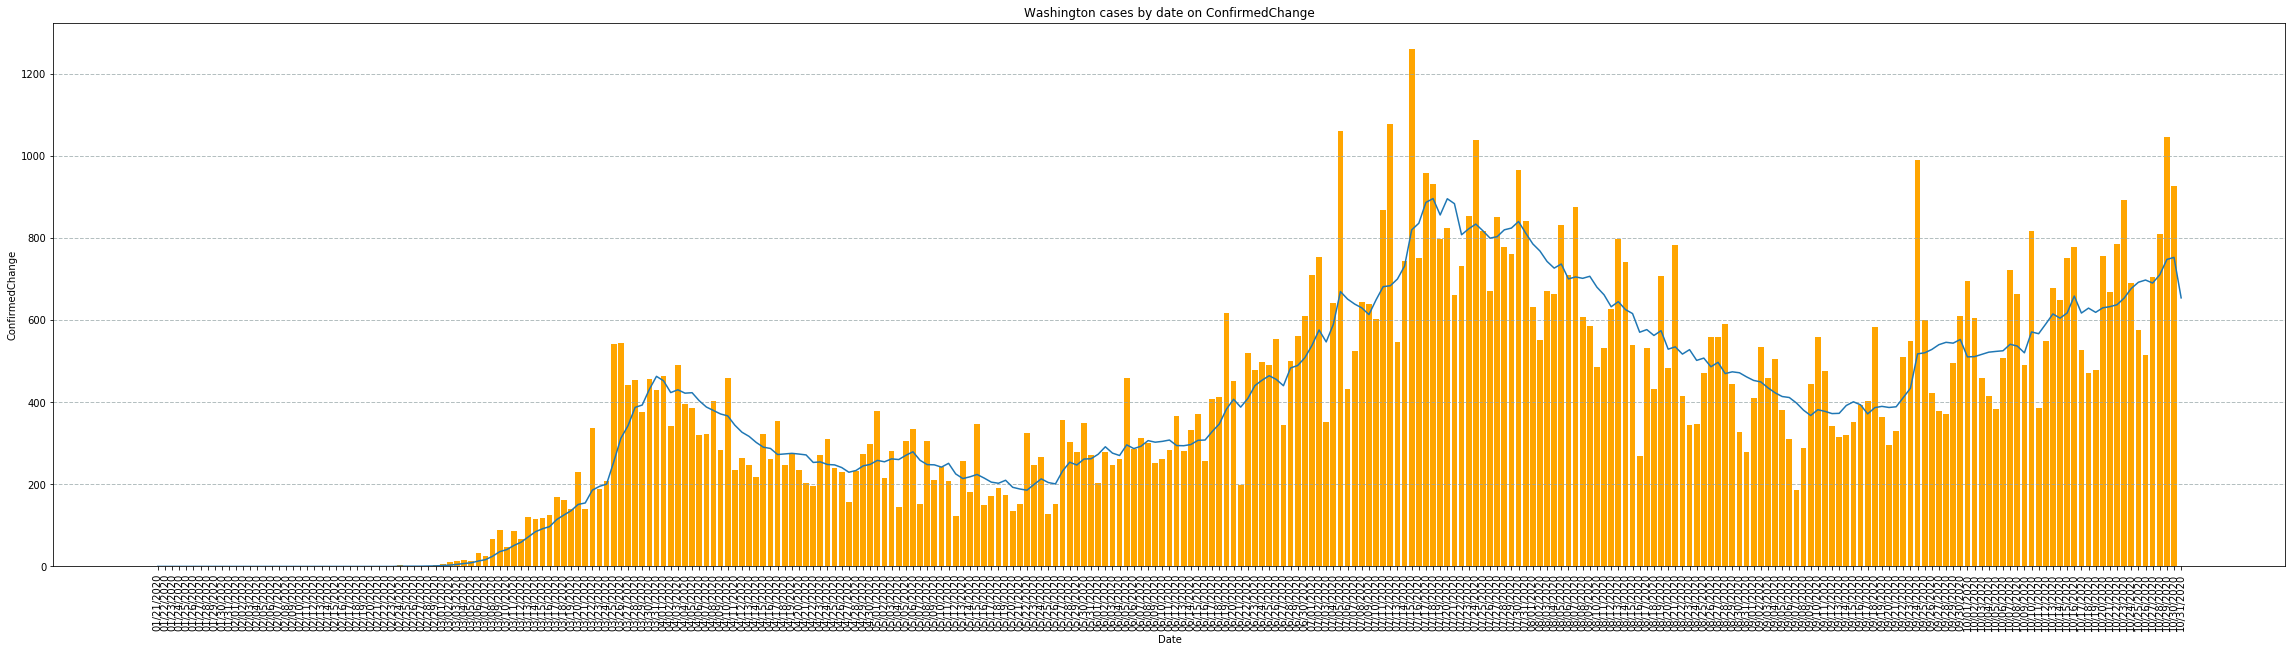

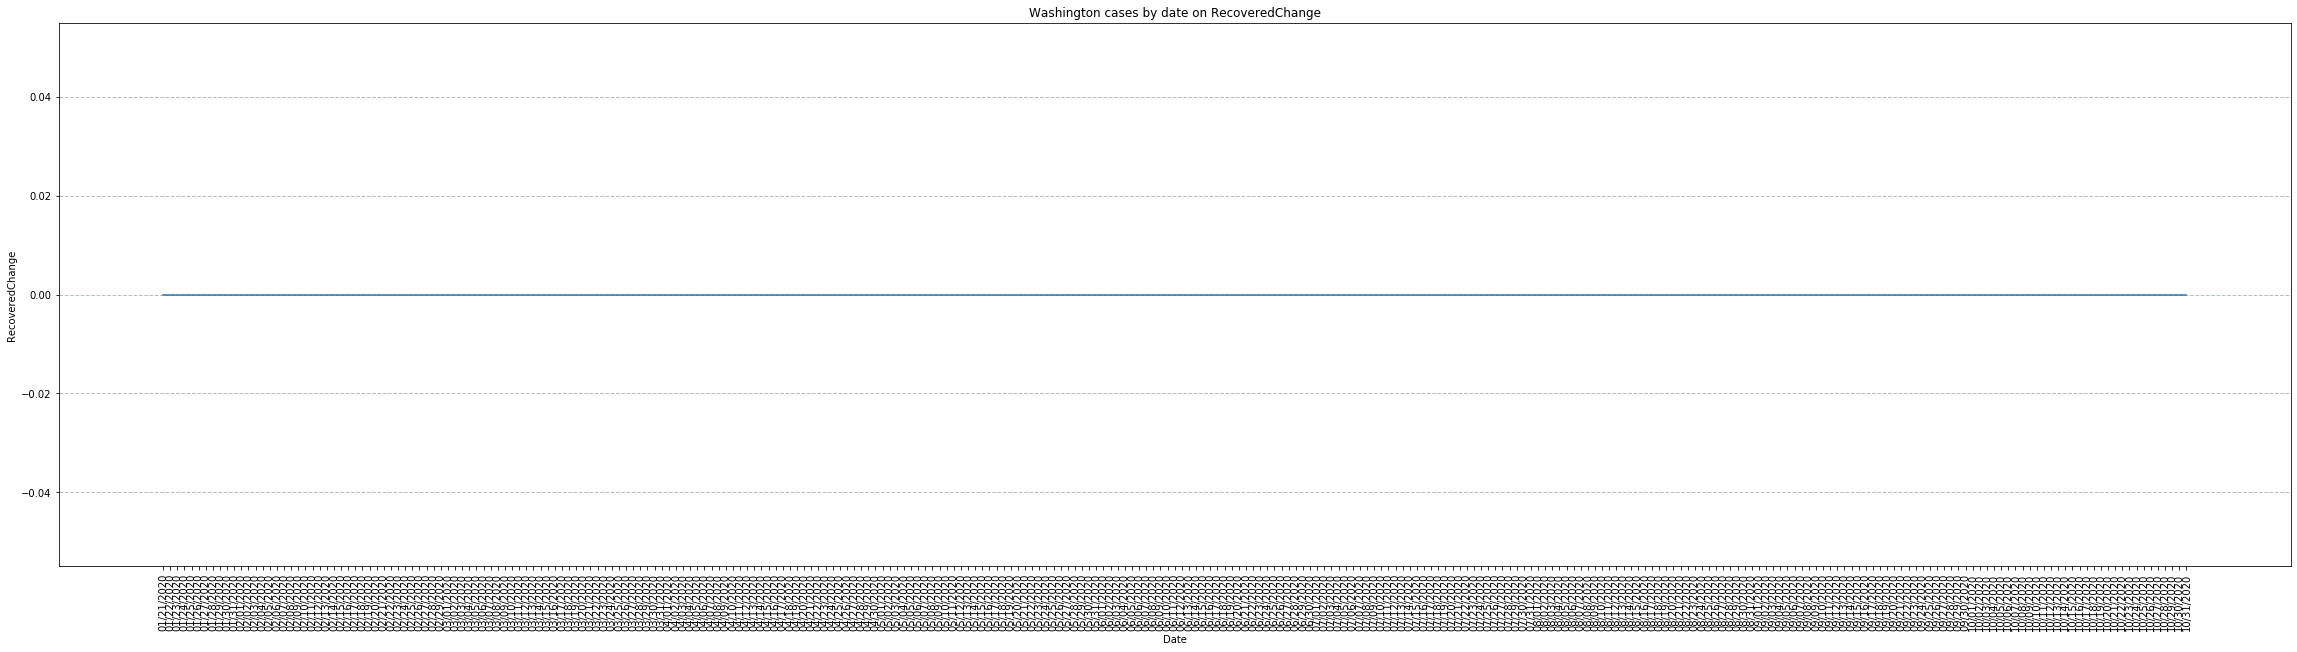

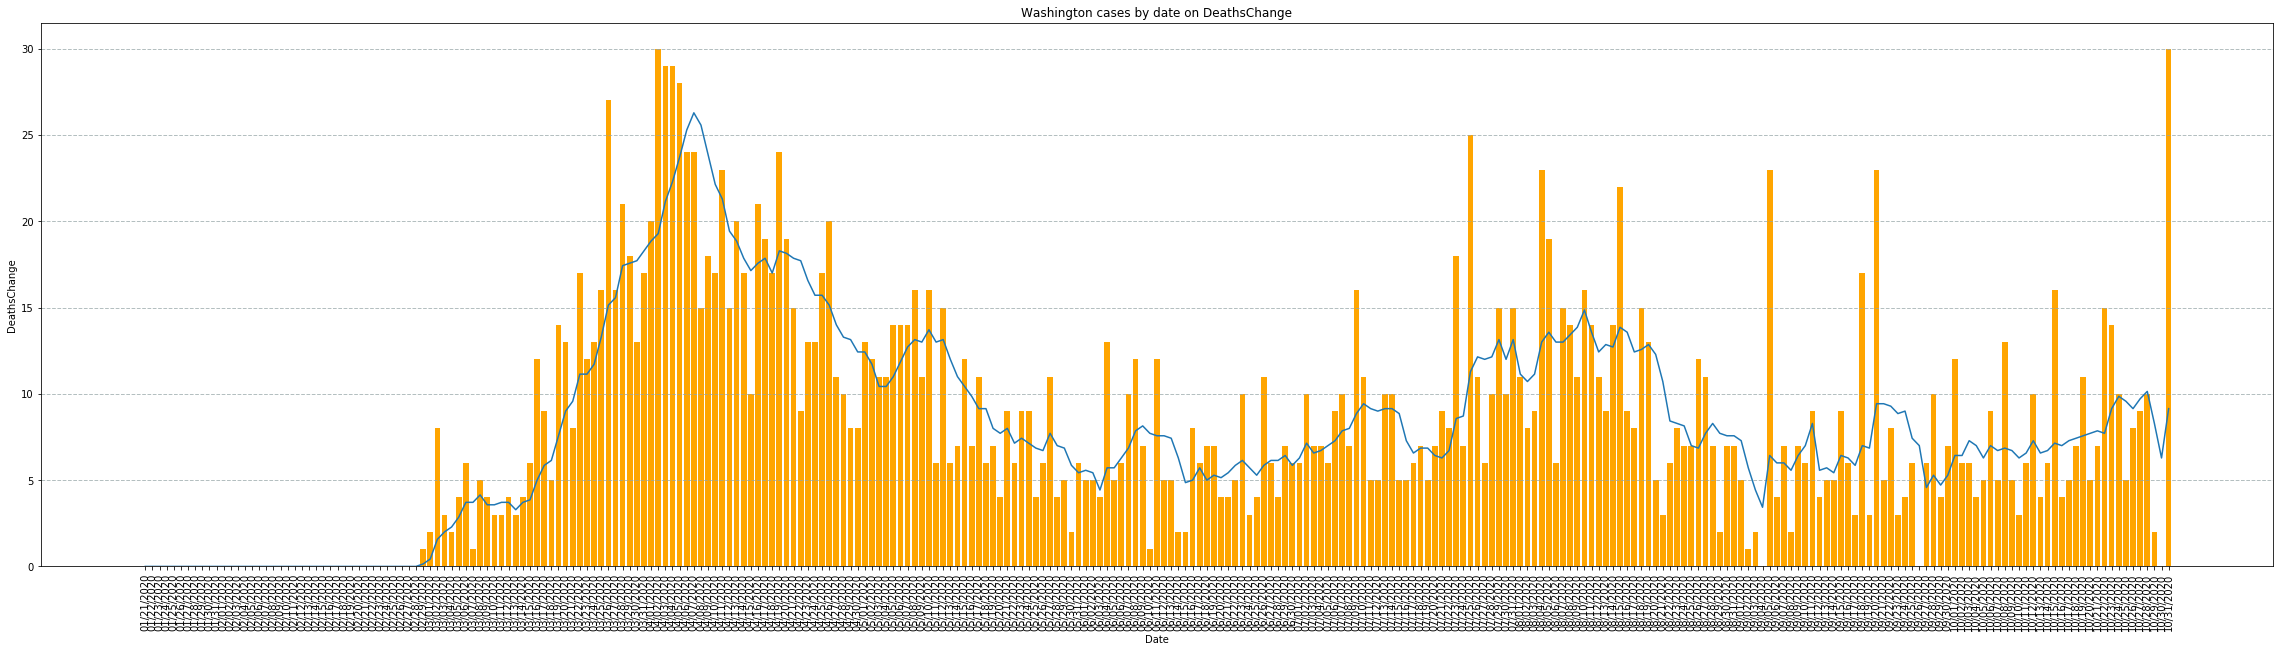

Mean for Confirmed Changed: 377.1929824561403
Features:
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]

Labels:
[0 0 0 0 0 0 0 0 0 0]
Training Set: 512, rows
Test Set: 58 rows
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Predicted labels:  [ 7. 11.  7.  9. 12.  6.  7.  8.  6.  6.]
Actual labels   :  [12  7  9 22  6  6  6  6  0  0]


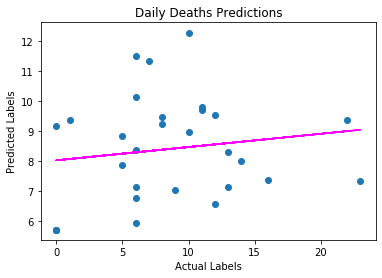

MSE: 33.551150008699516
RMSE: 5.792335453743983
R2: -0.0017935509946847006
Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  [0, 1]),
                                                 ('cat'

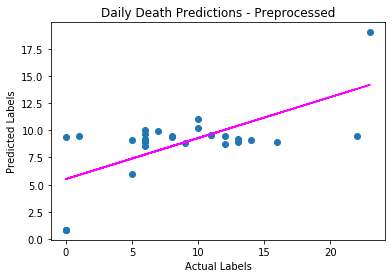

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(memory=None,
 

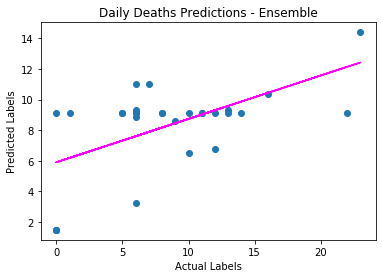

New sample: [443093.0, 197350.0]
Prediction: 6 deaths


In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import joblib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

#Store the Argentina data into a pandas' data frame
def readRawData():
    rawDataFrame = pd.read_csv('C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/Bing-covid19_data.csv',delimiter=',',header='infer')
    return rawDataFrame

# Create a bar plot of ConfirmedChange values in state variable by date.
def plot_ConfChange(rawDataFrame, country, column):
    fig, graph  = plt.subplots(figsize=(40, 10))
    graph.bar(x = raw_data.Updated, height = raw_data['{}'.format(column)], color = 'orange')
    graph.plot(raw_data.Updated, raw_data['{}Average'.format(column)], label="{} cases average".format(column))
    # Customize the chart
    plt.title('{} cases by date on {}'.format(country, column))
    plt.xlabel('Date')
    plt.ylabel('{}'.format(column))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)
    plt.xticks(rotation=90)
    # Display the plot
    plt.show()
    pass

def cleanNaN(raw_data):
    raw_data.Confirmed = raw_data.Confirmed.fillna(0)
    raw_data.ConfirmedChange = raw_data.ConfirmedChange.fillna(0)
    raw_data.Deaths = raw_data.Deaths.fillna(0)
    raw_data.DeathsChange = raw_data.DeathsChange.fillna(0)
    raw_data.Recovered = raw_data.Recovered.fillna(0)
    raw_data.RecoveredChange = raw_data.RecoveredChange.fillna(0)
    raw_data.AdminRegion1 = raw_data.AdminRegion1.fillna('0')
    raw_data.AdminRegion2 = raw_data.AdminRegion2.fillna('0')
    #remove negative values
    raw_data['ConfirmedChange'] = raw_data['ConfirmedChange'].astype(int)
    raw_data.ConfirmedChange = raw_data.ConfirmedChange.mask(raw_data.ConfirmedChange < 0, 0)
    raw_data['DeathsChange'] = raw_data['DeathsChange'].astype(int)
    raw_data.DeathsChange = raw_data.DeathsChange.mask(raw_data.DeathsChange < 0, 0)
    raw_data['RecoveredChange'] = raw_data['RecoveredChange'].astype(int)
    raw_data.RecoveredChange = raw_data.RecoveredChange.mask(raw_data.RecoveredChange < 0, 0)
    raw_data['Confirmed'] = raw_data['Confirmed'].astype(int)
    raw_data['Deaths'] = raw_data['Deaths'].astype(int)
    raw_data['Recovered'] = raw_data['Recovered'].astype(int)
    #remove columns that won't be used
    raw_data = raw_data.drop(['Latitude', 'Longitude', 'ISO2', 'ISO3'], axis=1)
    return raw_data

def query_country(raw_data, country):
    country_data = raw_data[(raw_data['Country_Region'] =="{}".format(country)) & (raw_data['AdminRegion1']=='0')]
    return country_data

def query_state(raw_data, state):
    state_data = raw_data[(raw_data['AdminRegion1'] =="{}".format(state)) & (raw_data['AdminRegion2']=='0')]
    return state_data

def add_7daysAverage(raw_data, column):
    index = list(raw_data.index.values)#this index is the where the raw_data starts as a reference with rawDataFrame
    sevenDaysMean = [0,0,0,0,0,0]
    for i in range(len(raw_data)-6):
        sevenDaysMean.append(raw_data.loc[index[0]+i:index[0]+6+i,'{}'.format(column)].mean())
    #Add the sevenDaysMean to the dataframe
    raw_data['{}Average'.format(column)] = sevenDaysMean
    return raw_data
   
#Run the Functions
#Load the raw data into a dataframe
raw_data = readRawData()

#Change cells with NaN to 0
raw_data = cleanNaN(raw_data)
raw_data2 = raw_data
#Query raw data for defined Country
country = 'United States'
raw_data = query_country(raw_data, country)

#Add column with 7 days average
raw_data = add_7daysAverage(raw_data, 'ConfirmedChange')
raw_data = add_7daysAverage(raw_data, 'RecoveredChange')
raw_data = add_7daysAverage(raw_data, 'DeathsChange')

#Plot the ConfirmedChange plot of the state variable.
plot_ConfChange(raw_data, country, 'ConfirmedChange')
plot_ConfChange(raw_data, country, 'RecoveredChange')
plot_ConfChange(raw_data, country, 'DeathsChange')

#run functions for sate
state = 'Washington'
raw_data = raw_data2
raw_data = query_state(raw_data, state)

#Add column with 7 days average
raw_data = add_7daysAverage(raw_data, 'ConfirmedChange')
raw_data = add_7daysAverage(raw_data, 'RecoveredChange')
raw_data = add_7daysAverage(raw_data, 'DeathsChange')

#Plot the ConfirmedChange plot of the state variable.
plot_ConfChange(raw_data, state, 'ConfirmedChange')
plot_ConfChange(raw_data, state, 'RecoveredChange')
plot_ConfChange(raw_data, state, 'DeathsChange')

#'Date from {}'.format(date_start)
print('Mean for Confirmed Changed:', raw_data.query('AdminRegion1=="{}"'.format(state)).ConfirmedChange.mean())

#------------------------------------------------------------------

#Separate features and labels
X, y = raw_data[['ConfirmedChange', 'RecoveredChange']].values, raw_data['DeathsChange'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)
print ('Training Set: %d, rows\nTest Set: %d rows' % (X_train.size, X_test.size))

# Fit a linear regression model on the training set
model = LinearRegression(normalize=False).fit(X_train, y_train)
print (model)

#Evaluate the train model
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

#Prediction Graph
%matplotlib inline
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#Calculate errors
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)


#train the model
# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0, 1]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression(normalize=False))])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

#Run tests
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels: ' ,y_test[:10])

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Death Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#different model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor())])
# train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

#Run tests
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions - Ensemble')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()


# Save the model as a pickle file
filename = 'C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/models/{}_deaths_predictions.pkl'.format(country)
joblib.dump(model, filename)

# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[443093,197350]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} deaths'.format(np.round(result[0])))


In [5]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[57579,18858]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} deaths'.format(np.round(result[0])))

New sample: [57579.0, 18858.0]
Prediction: 8 deaths


In [6]:
#passes  = pd.Series(df_students['Grade'] >= 60)
#df_students = pd.concat([df_students, passes.rename("Pass")], axis=1)

#print(raw_data.loc[0:7])
#i=1
#print(raw_data.loc[0+i:6+i,'ConfirmedChange'])
#print(raw_data.loc[0+i:6+i,'ConfirmedChange'].mean())

print(len(raw_data))
#print(raw_data)
sevenDaysMean = [0,0,0,0,0,0]
for i in range(len(raw_data)-6):
    sevenDaysMean.append(raw_data.loc[0+i:6+i,'ConfirmedChange'].mean())
    #new_data = pd.concat([test_data, sevenDaysMean.rename('average')], axis=1)

print(len(sevenDaysMean))
raw_data['ConfirmedChangeAverage'] = sevenDaysMean
print(raw_data)

raw_data = raw_data.drop(['Latitude', 'Longitude', 'ISO2', 'ISO3'], axis=1)

print(raw_data)
#new_data


282
282
              ID     Updated  Confirmed  ConfirmedChange  Deaths  \
930518    127483  01/21/2020          1                0       0   
930519  48825904  01/22/2020          1                0       0   
930520  48825906  01/23/2020          1                0       0   
930521  48825908  01/24/2020          1                0       0   
930522  48825910  01/25/2020          1                0       0   
...          ...         ...        ...              ...     ...   
930795  79858724  10/24/2020     102922              690    2302   
930796  79858729  10/25/2020     103503              581    2310   
930797  79858735  10/26/2020     104018              515    2318   
930798  79858742  10/27/2020     104743              725    2323   
930799  79724430  10/28/2020     104338                0    2350   

        DeathsChange  Recovered  RecoveredChange Country_Region AdminRegion1  \
930518             0          0                0  United States   Washington   
930519         

C:\Tools\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: "['Latitude' 'Longitude' 'ISO2' 'ISO3'] not found in axis"

In [ ]:
print(len(test_data))
print(test_data)
print(test_data['ConfirmedChange'])
sevenDaysMean = [0,0,0,0,0,0]

index = list(test_data.index.values)
print('index::', index[0])
#print('column::', test_data.index.row.get_loc('ConfirmedChange'))

for i in range(len(test_data)-6):
    sevenDaysMean.append(test_data.loc[index[0]+i:index[0]+6+i,'ConfirmedChange'].mean())
    #print(test_data.loc[0+i:6+i,'ConfirmedChange'])

print(len(sevenDaysMean))
test_data['ConfirmedChangeAverage'] = sevenDaysMean
print(test_data)

In [15]:
#US population by state
usa_popState = pd.DataFrame({'State':['California', 'Texas', 'Florida', 'New York', 'Pennsylvania', 'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan', 'New Jersey', 
                                       'Virginia', 'Washington', 'Arizona', 'Massachusetts', 'Tennessee', 'Indiana', 'Missouri', 'Maryland', 'Wisconsin', 'Colorado', 'Minnesota', 
                                       'South Carolina', 'Alabama', 'Louisiana', 'Kentucky', 'Oregon', 'Oklahoma', 'Connecticut', 'Utah', 'Iowa', 'Nevada','Arkansas', 
                                       'Mississippi', 'Kansas', 'New Mexico', 'Nebraska', 'West Virginia', 'Idaho', 'Hawaii', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island', 
                                       'Delaware', 'South Dakota', 'North Dakota', 'Alaska', 'District of Columbia', 'Vermont', 'Wyoming'],
                             'Population':[39512223,28995881,21477737,19453561,12801989,12671821,11689100,10617423,10488084,9986857,8882190,8535519,7614893,7278717,6892503,6829174,
                                            6732219,6137428,6045680,5822434,5758736,5639632,5148714,4903185,4648794,4467673,4217737,3956971,3565287,3205958,3155070,3080156,
                                            3017804,2976149,2913314,2096829,1934408,1792147,1787065,1415872,1359711,1344212,1068778,1059361,973764,884659,762062,731545,705749,623989,
                                            578759]})

#make all population int()
usa_popState['Population'] = usa_popState['Population'].astype(int)

#Load the raw data into a dataframe
test_data = readRawData()

#Change cells with NaN to 0
test_data = cleanNaN(test_data)

date = test_data['Updated'].values[-1]
print('Report from:', date)

confirmed_percentage = []
confirmed_cases_list = []
death_percentage = []
death_cases_list = []
for i in range(len(usa_popState)):
    #Get the state info by date and state
    state_data = test_data[(test_data['Updated'] =="{}".format(date)) & (test_data['AdminRegion1']=='{}'.format(usa_popState.loc[i,'State'])) & (test_data['AdminRegion2'] == '0')]
    #Get the confirmed cases by state and change it int()   
    confirmed_cases = int(state_data['Confirmed'].astype(int))
    confirmed_cases_list.append(confirmed_cases)
    #state infection percentage
    percentage = 100*(confirmed_cases/usa_popState.loc[i,'Population'])
    confirmed_percentage.append(percentage)
    #Get the death cases by state and change it int()   
    death_cases = int(state_data['Deaths'].astype(int))
    death_cases_list.append(death_cases)
    #state deaths percentage
    percentage = 100*(death_cases/confirmed_cases)#calculate using confirmed cases instead of population: usa_popState.loc[i,'Population'])
    death_percentage.append(percentage)
    pass

usa_popState['StateInfectionPerc'] = confirmed_percentage
usa_popState['ConfirmedCases'] = confirmed_cases_list
usa_popState['DeathPerc'] = death_percentage

#sorted by percentage
usa_popState = usa_popState.sort_values('StateInfectionPerc', ascending=False)


print('sorted by Infections percentage:')
usa_popState

Report from: 10/31/2020
sorted by Infections percentage:


,State,Population,StateInfectionPerc,ConfirmedCases,DeathPerc
46,North Dakota,762062,5.910674,45043,1.178874
45,South Dakota,884659,4.998084,44216,0.961191
33,Mississippi,2976149,4.037432,120160,2.774634
30,Iowa,3155070,4.036582,127357,1.346608
24,Louisiana,4648794,4.014998,186649,3.171193
23,Alabama,4903185,3.921635,192285,1.543022
19,Wisconsin,5822434,3.870718,225370,0.901185
15,Tennessee,6829174,3.817036,260672,1.286291
2,Florida,21477737,3.736646,802547,2.088476
32,Arkansas,3017804,3.717604,112190,1.715839


In [16]:
print('sorted by Death percentage:')
usa_popState = usa_popState.sort_values('DeathPerc', ascending=False)
usa_popState

sorted by Death percentage:


,State,Population,StateInfectionPerc,ConfirmedCases,DeathPerc
28,Connecticut,3565287,1.997231,71207,6.482509
14,Massachusetts,6892503,2.300703,158576,6.300449
10,New Jersey,8882190,2.697859,239629,6.076477
3,New York,19453561,2.620266,509735,5.066162
40,New Hampshire,1359711,0.815173,11084,4.357633
4,Pennsylvania,12801989,1.624958,208027,4.235989
9,Michigan,9986857,1.784145,178180,4.119430
48,District of Columbia,705749,2.429192,17144,3.768082
43,Rhode Island,1059361,3.103191,32874,3.653343
24,Louisiana,4648794,4.014998,186649,3.171193


In [ ]:
# Separate features and labels
X, y = ArgRawData[['ConfirmedChange', 'RecoveredChange']].values, ArgRawData['DeathsChange'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

#numeric_features = ['Confirmed','ConfirmedChange', 'Deaths', 'DeathsChange', 'Recovered', 'RecoveredChange']

In [ ]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

print ('Training Set: %d, rows\nTest Set: %d rows' % (X_train.size, X_test.size))

In [ ]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression(normalize=False).fit(X_train, y_train)
print (model)

In [ ]:
#Evaluate the train model

import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

You can quantify the residuals by calculating a number of commonly used evaluation metrics. We'll focus on the following three:

- **Mean Square Error (MSE)**: The mean difference between predicted and actual, squared. This yields a relative metric in which the smaller the value, the better the fit of the model
- **Root Mean Square Error (RMSE)**: The square root of the MSE. This yields an absolute metric in the same unit as the label (in this case, numbers of deaths). The smaller the value, the better the model (in a simplistic sense, it represents the average number of deaths by which the predictions are wrong!)
- **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>**: A relative metric in which the higher the value, the better the fit of the model. In essence, this metric represents how much of the variance between predicted and actual label values the model is able to explain.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

In [ ]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0, 1]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression(normalize=False))])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

In [ ]:
predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels: ' ,y_test[:10])

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Death Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

### Try a Different Algorithm

The linear regression algorithm we used to train the model has some predictive capability, but there are many kinds of regression algorithm we could try, including:

- **Linear algorithms**: Not just the Linear Regression algorithm we used above (which is technically an *Ordinary Least Squares* algorithm), but other variants such as *Lasso* and *Ridge*.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

Let's try training our regression model by using an ensemble algorithm called **Gradient Boosting**. We can do this by just changing the last step of the pipeline.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor())])


# train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

In [ ]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Deaths Predictions - Ensemble')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [ ]:
#Use the trained model
import joblib

# Save the model as a pickle file
#filename = 'C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/models/Arg_deaths_predictions_fromprovincesdata.pkl'
filename = 'C:/Users/paulo/Documents/Paulo/Covid19_Data/DataFiles/models/Arg_deaths_predictions.pkl'
joblib.dump(model, filename)

In [ ]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[17096,0]]).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} deaths'.format(np.round(result[0])))